In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
plt.rcParams['figure.figsize'] = (12.0, 8.0)

## Thermistor Callibration
I taped 3 10k thermistors and a well callibrated thermocouple to a copper pot using aluminum tape, wrapped the whole thing in a dry towel and filled it with hot water.

The hope is that I can callibrate the 3 thermistors against the thermocouple.

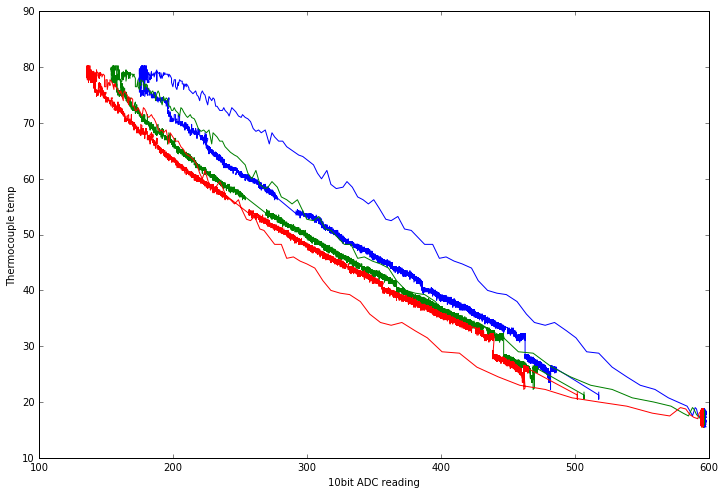

In [7]:
data = pd.read_csv("./data/temp_calib.txt", sep = "\t", header =-1)
tcouple = data[0]
x = np.linspace(0,1, 100)
plt.plot(data[1], tcouple, data[2], tcouple, data[3], tcouple)
plt.ylabel("Thermocouple temp")
plt.xlabel("10bit ADC reading")

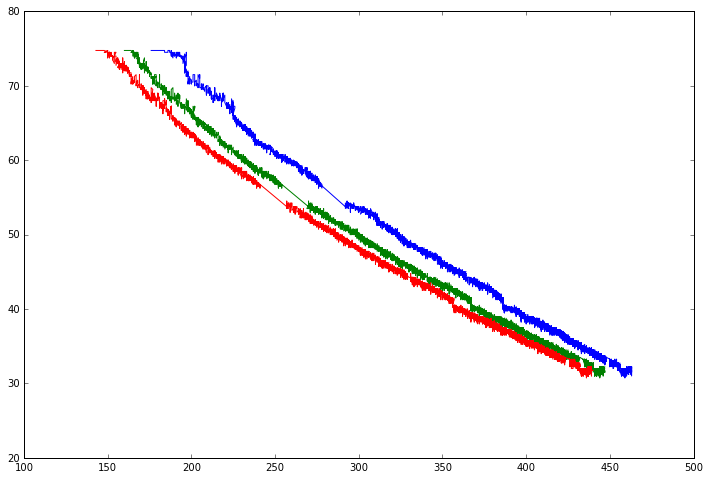

In [259]:
f = data[(30 < data[0]) & (data[0] < 75) & (data.index > 1300)]
x = f[0]
ax = plt.gca()
ax.set_ylim(20,80)
ax.plot(f[1], x, f[2], x, f[3], x)

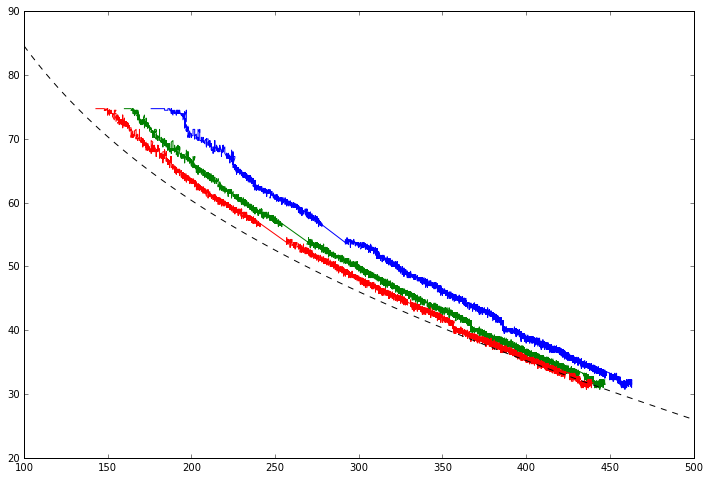

In [288]:
import math

def temp(x, R0 = 1e4, B = 3977.0):
    T0 = 273.15
    #the thermistor has R1 when T = T1
    T1 = 25
    R1 = 1e4
    alpha = x / 1023.0
    R = alpha / (1.0 - alpha) * R0;
    t = 1.0 / (1.0/(T0 + T1) + 1/B * np.log(R / R1)) - T0
    return t

X = np.linspace(100, 500, 100)
plt.plot(f[1], x, f[2], x, f[3], x, X, temp(X), "--k")

[ 9542.69096558  3207.01863418] [ 9997.69466448  3457.26246182] [ 10176.32671334   3619.82339712]


''

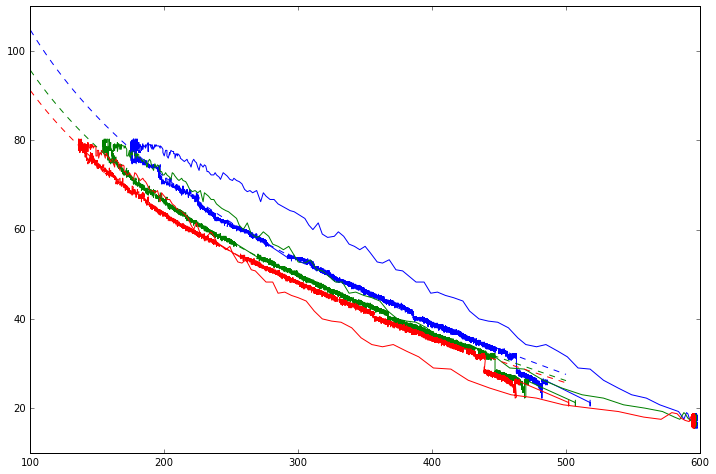

In [265]:
from scipy.optimize import curve_fit
popt1, _ = curve_fit(temp, f[1], x, p0 = (9840, 3977))
popt2, _ = curve_fit(temp, f[2], x, p0 = (9840, 3977))
popt3, _ = curve_fit(temp, f[3], x, p0 = (9840, 3977))
print(popt1, popt2, popt3)

plt.plot(data[1], data[0], data[2], data[0], data[3], data[0], X, temp(X, *popt1), "--b",X, temp(X, *popt2), "--g",X, temp(X, *popt3), "--r")
;

poly coeffs  [ -6.31649088e-07   7.72770053e-04  -4.46595489e-01   1.34814268e+02]
log coeffs  [ -8.63372375  51.38492006  41.27823108]
stein coeffs  [  9.54269094e+03   3.20701865e+03   1.19019815e+12]
R0: 9542.690965575866, B: 3207.0186341787744


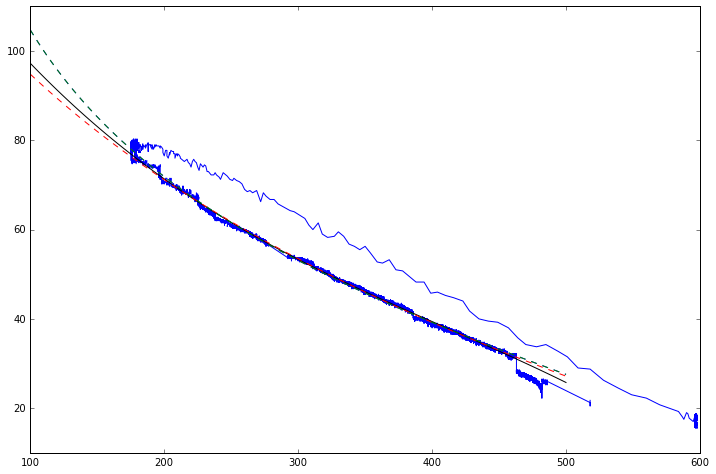

In [295]:
#third degree polynomial
poly = np.polyfit(f[1], x, 3)
print("poly coeffs ", poly)

#third degree polynomial in ln(x)
from numpy import log
logpoly = np.polyfit(log(f[1]), x, 2)
print("log coeffs ", logpoly)

def steinhart(x, R0 = 1e4, B = 3977.0, A = 1e6):
    T0 = 273.15
    T1 = 25
    #the thermistor has R1 when T = T1
    R1 = 1e4
    alpha = x / 1023.0
    R = alpha / (1.0 - alpha) * R0;
    t = 1.0 / (1.0/(T0 + T1) + 1/B * np.log(R / R1) + 1/A * np.log(R / R1)**3) - T0
    return t

stein, _ = curve_fit(steinhart, f[1], x, p0 = (1e4, 3977, 1e6))
print("stein coeffs ", stein)
print("R0: {}, B: {}".format(*popt1))

ax = plt.gca()
#ax.set_ylim(60, 100)

ax.plot(data[1], data[0], 
         X, temp(X, *popt1), "--b",
         X, np.polyval(poly, X),"-k",
         X, np.polyval(logpoly, log(X)), "--r",
         X, steinhart(X, *stein), "--g"
        )

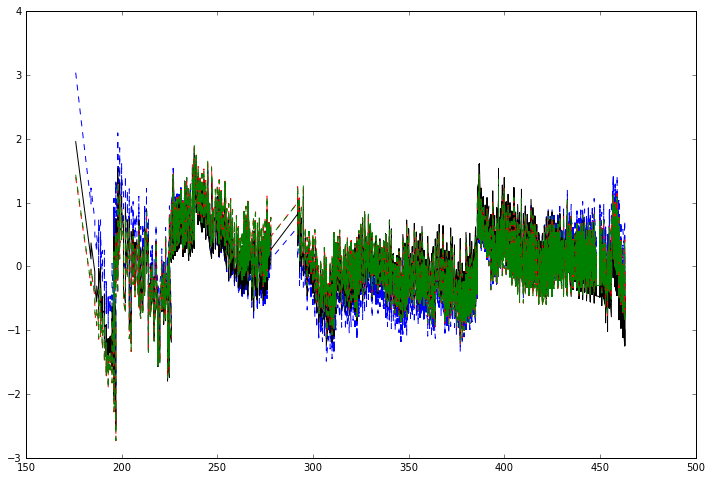

In [276]:
plt.plot(f[1], temp(f[1], *popt1) - x, "--b",
         f[1], np.polyval(poly, f[1]) - x,"-k",
         f[1], np.polyval(logpoly, log(f[1])) - x, "--r",
         f[1], steinhart(f[1], *stein) - x, "--g"
        )

In [269]:
#try rescaling x
u = x / 500
#third degree polynomial
upoly = np.polyfit(f[1], u, 2)
print("upoly coeffs ", upoly)

upoly coeffs  [  2.82087270e-07  -4.86727942e-04   2.27874840e-01]


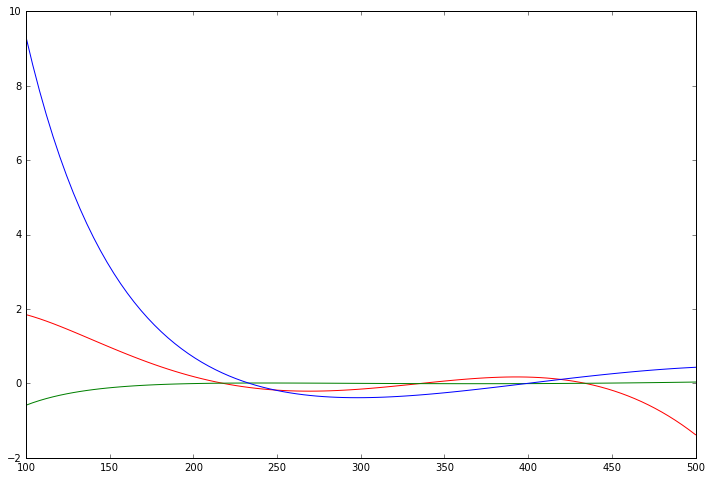

In [278]:
X = np.linspace(100, 500, 100)
plt.plot(
         X, np.polyval(poly, X) - steinhart(X, *stein), "r",
         X, np.polyval(logpoly, log(X)) - steinhart(X, *stein), "g",
         X, temp(X, *popt1) - steinhart(X, *stein), "b",
        )